In [ ]:
import transformers
print(transformers.__version__)


4.41.0


In [ ]:
import transformers
print(transformers.__version__)


4.41.0


In [ ]:
import pandas as pd
import numpy as np
from cleantext import clean
import re
from transformers import XLNetTokenizer, XLNetForSequenceClassification, TrainingArguments, Trainer, pipeline
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import datasets
import evaluate
import random

### Preprocessing the Data

In [ ]:
data_train = pd.read_csv("./datasets/emotion-labels-train.csv")
data_test = pd.read_csv("./datasets/emotion-labels-test.csv")
data_val = pd.read_csv("./datasets/emotion-labels-val.csv")

In [ ]:
data_train

,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy
4,I feel so blessed to work with the family that...,joy
...,...,...
3608,@VivienLloyd Thank you so much! Just home - st...,sadness
3609,Just put the winter duvet on ☃️❄️🌬☔️,sadness
3610,@SilkInSide @TommyJoeRatliff that's so pretty!...,sadness
3611,@BluesfestByron second artist announcement loo...,sadness


In [ ]:
data = pd.concat([data_train, data_test, data_val], ignore_index=True)

In [ ]:
print(clean.__doc__)


Given a raw string, return cleaned text

    :param text: Input text to clean
    :param clean_all: Execute all cleaning operations
    :param extra_spaces: Remove extra white spaces
    :param stemming: Stem the words
    :param stopwords: Remove stop words
    :param lowercase: Convert to lowercase
    :param numbers: Remove all digits
    :param punct: Remove all punctuations
    :param reg: Regular expression for removing or replacing
    :param reg_replace: Replace the part with regular expression(reg)
    :param stp_lang: Language for stop words
    :return: Cleaned text
    


In [ ]:
data['text_clean'] = data['text'].apply(lambda x: clean(x, punct=True))

In [ ]:
data

,text,label,text_clean
0,Just got back from seeing @GaryDelaney in Burs...,joy,Just got back from seeing GaryDelaney in Bursl...
1,Oh dear an evening of absolute hilarity I don'...,joy,Oh dear an evening of absolute hilarity I dont...
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy,Been waiting all week for this game ❤️❤️❤️ che...
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,gardinerlove Thank you so much Gloria Youre s...
4,I feel so blessed to work with the family that...,joy,I feel so blessed to work with the family that...
...,...,...,...
7097,Common app just randomly logged me out as I wa...,sadness,Common app just randomly logged me out as I wa...
7098,"I'd rather laugh with the rarest genius, in be...",sadness,Id rather laugh with the rarest genius in beau...
7099,If you #invest in my new #film I will stop ask...,sadness,If you invest in my new film I will stop askin...
7100,"Just watched Django Unchained, Other people ma...",sadness,Just watched Django Unchained Other people may...


<Axes: xlabel='label'>

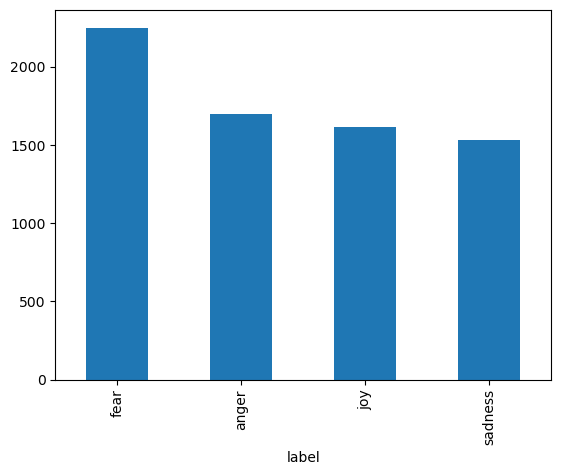

In [ ]:
data['label'].value_counts().plot(kind="bar")

In [ ]:
g = data.groupby('label')
data = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))

/tmp/ipykernel_3850930/2135407547.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))


<Axes: xlabel='label'>

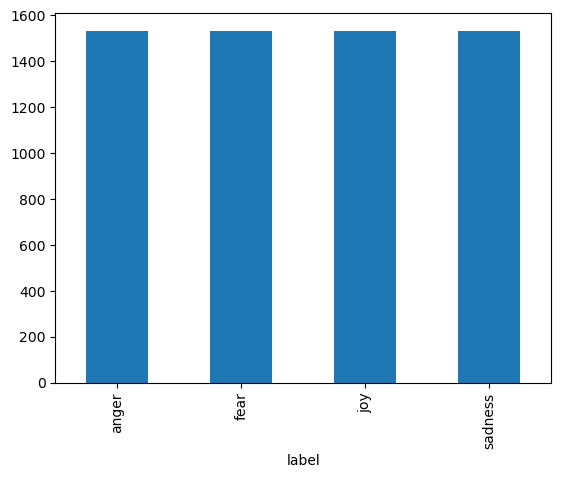

In [ ]:
data['label'].value_counts().plot(kind="bar")

In [ ]:
data['label_int'] = LabelEncoder().fit_transform(data['label'])

In [ ]:
NUM_LABELS = 4

In [ ]:
train_split, test_split = train_test_split(data, train_size=0.8)
train_split, val_split = train_test_split(train_split, train_size=0.9)

In [ ]:
print(len(train_split))
print(len(test_split))
print(len(val_split))

4414
1227
491


In [ ]:
train_df = pd.DataFrame({
    "label": train_split.label_int.values,
    "text": train_split.text_clean.values
})

test_df = pd.DataFrame({
    "label": test_split.label_int.values,
    "text": test_split.text_clean.values
})

In [ ]:
train_df = datasets.Dataset.from_dict(train_df)
test_df = datasets.Dataset.from_dict(test_df)

In [ ]:
dataset_dict = datasets.DatasetDict({"train": train_df, "test":test_df})

In [ ]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 4414
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 1227
    })
})

### Create Embeddings

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", max_length=128, truncation=True)

In [ ]:
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

Map:   0%|          | 0/4414 [00:00<?, ? examples/s]

Map:   0%|          | 0/1227 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4414
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1227
    })
})

In [ ]:
small_train_dataset = tokenized_datasets['train'].shuffle(seed=42).select(range(100))
small_eval_dataset = tokenized_datasets['test'].shuffle(seed=42).select(range(100))

### Finetuning the Model

In [ ]:
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased',
                                                       num_labels = NUM_LABELS,
                                                       id2label={0: 'anger', 1: 'fear', 2:'joy', 3:'sadness'})

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
metric = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
training_args = TrainingArguments(output_dir="test_trainer", eval_strategy="epoch", num_train_epochs=3)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

  0%|          | 0/39 [00:00<?, ?it/s]

/home/annabale7/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.4359272718429565, 'eval_accuracy': 0.21, 'eval_runtime': 34.3509, 'eval_samples_per_second': 2.911, 'eval_steps_per_second': 0.378, 'epoch': 1.0}


/home/annabale7/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.4140188694000244, 'eval_accuracy': 0.26, 'eval_runtime': 38.9232, 'eval_samples_per_second': 2.569, 'eval_steps_per_second': 0.334, 'epoch': 2.0}


/home/annabale7/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.418652057647705, 'eval_accuracy': 0.28, 'eval_runtime': 31.4955, 'eval_samples_per_second': 3.175, 'eval_steps_per_second': 0.413, 'epoch': 3.0}
{'train_runtime': 440.2829, 'train_samples_per_second': 0.681, 'train_steps_per_second': 0.089, 'train_loss': 1.3850503579164162, 'epoch': 3.0}


TrainOutput(global_step=39, training_loss=1.3850503579164162, metrics={'train_runtime': 440.2829, 'train_samples_per_second': 0.681, 'train_steps_per_second': 0.089, 'total_flos': 21366375321600.0, 'train_loss': 1.3850503579164162, 'epoch': 3.0})

### Evaluate model

In [ ]:
trainer.evaluate()

/home/annabale7/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.418652057647705,
 'eval_accuracy': 0.28,
 'eval_runtime': 53.2418,
 'eval_samples_per_second': 1.878,
 'eval_steps_per_second': 0.244,
 'epoch': 3.0}

In [ ]:
# model.save_pretrained("fine_tuned_model")

In [ ]:
fine_tuned_model = XLNetForSequenceClassification.from_pretrained('fine_tuned_model')

In [ ]:
clf = pipeline("text-classification", fine_tuned_model, tokenizer=tokenizer)

In [ ]:
rand_int = random.randint(0, len(val_split))
print(val_split['text_clean'][rand_int])
answer = clf(val_split['text_clean'][rand_int], top_k=None)

/tmp/ipykernel_3850930/1812021649.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(val_split['text_clean'][rand_int])
/tmp/ipykernel_3850930/1812021649.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  answer = clf(val_split['text_clean'][rand_int], top_k=None)


dcmma ChampionsFight think shes afraid to fight Holly One can only imagine what goes through her head when she thinks of Cyborg


In [ ]:
print(answer)

[{'label': 'joy', 'score': 0.3449900448322296}, {'label': 'sadness', 'score': 0.2954856753349304}, {'label': 'anger', 'score': 0.2443746030330658}, {'label': 'fear', 'score': 0.11514966189861298}]
